In [5]:
import numpy as np
import pandas as pd
import requests
import json
import numpy as np
import talib as tl
import matplotlib.pyplot as plt
import random
from scipy.optimize import differential_evolution
import time

In [3]:
def download_dataset(dic,url):
    dataset=np.zeros((2001,len(dic)))#careful avec le +1
    j=0
    for symb in dic:
        r= requests.get(url+'fsym='+symb+'&tsym=USD&limit=2000&aggregate=1&e=CCCAGG')#0.5
        r=r.json()
        r=r["Data"]
        for i in range(0,len(r)):
            dataset[i][j]=r[i]["close"]
        j+=1
    return dataset


# giving the dataset, where are the close prices (colum number), the number of the day for the KAMA and TEMA
# it returns the same dataset and the indicators columns
def add_indicator(dataset,step_past,dema1,dema2,column_number=0):
    dataset = dataset.astype('float')#si tu veux transformer le type des donnees
    dema1=tl.KAMA(dataset[:,column_number],dema1)[-step_past:]
    dema2=tl.TEMA(dataset[:,column_number],dema2)[-step_past:]

    dataset=dataset[-step_past:,:]
    dema1,dema2=np.reshape(dema1,(-1,1)),np.reshape(dema2,(-1,1))
    return dema1,dema2,dataset

# x is the dataset (with close prices, dates, highest and lowest prices)
# dema1 and dema2 are 2 columns which contains the indicator for each day
# cash = the cash you've got to start
# column_number= column where are the close prices
# this function simulates a simple crossover strategy with a given dataset
def simple_crossover_dema(x,dema1,dema2,fees=0.0025,cash=100,column_number=0,to_plot=False):
    buy_and_hold_start=cash/x[0,0]
    bet=0
    nb_trade=0
    wallet=[cash+bet]
    buy_and_hold=[]
    for i in range(1,dema1.shape[0]):
#         simple crossover
#         if the first indicator is higher than the second  one and we haven't already bought, then we must buy
        if dema1[i,0]>dema2[i,0] and cash>0:
            nb_trade+=1
            bet=cash*(1-fees)/x[i,0]
            cash=0
#         if the first indicator is lower than the second one and we still have money on this currency, then we have to
#          withdraw
        elif dema2[i,0]>dema1[i,0] and bet>0:
            nb_trade+=1
            cash=bet*x[i,0]*(1-fees)
            bet=0
        wallet.append(cash+bet*x[i,0])
        buy_and_hold.append(buy_and_hold_start*x[i,0])
    if to_plot:
        print nb_trade,' trades'
        plt.plot(wallet,label='Wallet')
        plt.plot(buy_and_hold,label='Buy and Hold')
        plt.legend(loc='upper right')
        plt.show()
    return wallet[-1]
        
# step_past=240 (10 days)
# cash_per_currency is in case you would like to use several currencies
# this function is generic
# use it to test many combinaisons of indicator
def wallet(dataset,cash_per_currency=20,step_past=720,dema1_value=16,dema2_value=59,to_plot=False):
    wallet=0
    for i in range(dataset.shape[1]):
#         get the indicator columns
        dema1,dema2,x=add_indicator(dataset,step_past,dema1_value,dema2_value,column_number=i)
    
#         given the 2 indicator columns, simple_crossover_dema just has to compare each single value of the 2 columns
        wallet+=simple_crossover_dema(x,dema1,dema2,cash=cash_per_currency,column_number=i,to_plot=to_plot)
    return wallet


# compare every combinaison possible of the two indicator choosen
# return the best two indicator and the money make
def compare_dema():
    list=[]
    assets=['BTC']
    URL='https://min-api.cryptocompare.com/data/histohour?'
    dataset=download_dataset(assets,URL)
#     test the first indicator between 10 and 100
    for i in range(10,100):
#         we guess the second indicator must be higher than the first one (it's long and the first one is short)
        for j in range(i+1,100):
            list.extend([i,j,wallet(dataset,dema1_value=i,dema2_value=j)])
    result=np.array(list)
    result=result.reshape((-1,3))
    print result[np.argmax(result[:,2]),:]    
    

def single_dema(dema1,dema2,assets,step_past):
    URL='https://min-api.cryptocompare.com/data/histohour?'
    dataset=download_dataset(assets,URL)
    return wallet(dataset,dema1_value=dema1,dema2_value=dema2,step_past=step_past,to_plot=True)


# search the best combinaison of indicators then print out the wallet if we had used this combinaison
def best_single_dema(assets):
    list=[]
    URL='https://min-api.cryptocompare.com/data/histohour?'
    dataset=download_dataset(assets,URL)
    for i in range(10,100):
        for j in range(i+1,100):
            list.extend([i,j,wallet(dataset,dema1_value=i,dema2_value=j)])
    result=np.array(list)
    result=result.reshape((-1,3))
    dema1=result[np.argmax(result[:,2]),:][0]
    dema2=result[np.argmax(result[:,2]),:][1]
    print dema1,dema2
    return wallet(dataset,dema1_value=dema1,dema2_value=dema2,to_plot=True)
    

In [6]:
compare_dema()

[ 19.          95.          38.79653191]


11.0 14.0
64  trades


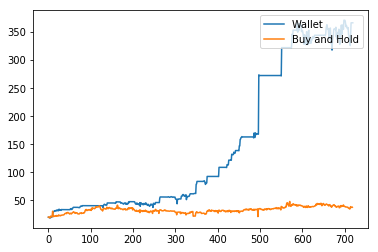

366.472493418
346.472493418  euros


In [7]:
# assets=['BTC','ETH','XRP','LTC','ETC','DASH','GNT','DOGE','ARK','USDT','REP','BCN','ZEC','ANS']
assets=['HKG']
sum=0
for i in assets:
    a=best_single_dema([i])#75,76
    sum+=a
    print a

print sum-len(assets)*20,' euros'

14  trades


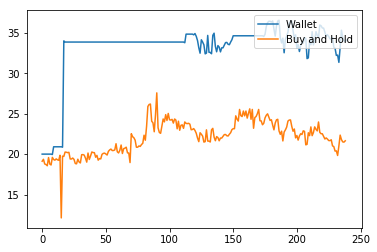

In [8]:
assets=['HKG']
a=single_dema(15,16,assets,240)#75,76